# Анализ гипотез по увеличению выручки в интернет-магазине.

**Цель исследования** - проанализировать имеющиеся гипотезы по увеличению выручки в интернет-магазине, принять решение по результатам А/В тестирования. 

**Ход исследования** - перед нами 3 датасета от отдела маркетинга интернет-магазина с информацией о гипотезах, заказчиках и заказах. Требуется изучить полученные датасеты. Приотизировать сформулированные гипотезы и провести А/В тестирование.

#### Описание данных

- Данные для первой части

Файл /datasets/hypothesis.csv.

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
    
- Данные для второй части

Файл /datasets/orders.csv. 

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. Скачать датасет

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Этапы исследования:
1. [Шаг 1. Загрузка данных и подготовка их к анализу](#general_id)
2. [Шаг 2. Приоритизация гипотез с помощью применения метода ICE и RICE](#step_two)
3. [Шаг 3. Анализ A/B-теста](#step_three)
- 3.1 [Стабильность кумулятивных метрик](#step_three_one)
- 3.2 [Анализ выбросов и всплесков: крайние значения данных](#step_three_two)
- 3.3 [Анализ A/B-теста шаг за шагом](#step_three_three)
- 3.3.1 [Определение статистически значимых различий между группами по «сырым» данным](#step_three_three_one)
- 3.3.2 [Определение статистически значимых различий между группами по «очищенным» данным](#step_three_three_two)
4. [Общий вывод](#conclusion_id)

## Шаг. Загрузка данных и подготовка их к анализу.
<a id=general_id></a>
Загрузим данные о гипотезах, визитах и заказах. Оптимизируем данные для анализа и убедимся, что тип данных в каждой колонке — правильный. Путь к файлам:
- /datasets/hypothesis.csv.
- /datasets/orders.csv. 
- /datasets/visitors.csv.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import datetime as dt
import scipy.stats as stats

In [2]:
hypothesis=pd.read_csv('/datasets/hypothesis.csv')
orders=pd.read_csv('/datasets/orders.csv')
visitors=pd.read_csv('/datasets/visitors.csv')

Создадим функцию research для изучения данных в таблице.

In [3]:
def research (data):
    data.info(memory_usage='deep')
    display(data.head(11))
    display(data.describe())
    print('Количество дубликатов',data.duplicated().sum())

Изучим таблицу hypothesis

In [4]:
research(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 2.7 KB


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Количество дубликатов 0


Весь текст гипотез не помещается в ячейку. Определим заданное максимальное кол-во символов и увеличим это значение на 250. А также приведем наименование колонок к нижнему регистру.

In [5]:
pd.options.display.max_colwidth

50

In [6]:
pd.options.display.max_colwidth=125


In [7]:
hypothesis.columns = hypothesis.columns.str.lower()

In [8]:
research(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 4.1 KB


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,reach,impact,confidence,efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Количество дубликатов 0


In [9]:
research(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 174.3 KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Количество дубликатов 0


Приведем наименование колонок к нижнему регистру и зададим формат даты для столбца date

In [10]:
orders.columns = orders.columns.str.lower()

In [11]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
research(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 105.3 KB


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


,transactionid,visitorid,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Количество дубликатов 0


In [13]:
research(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 8.2 KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


Количество дубликатов 0


Зададим формат даты для колонки date

In [14]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

8300375

In [15]:
print(orders.groupby('visitorid').agg({'group':pd.Series.nunique}).query('group>1').count())
crossing = orders.groupby('visitorid',as_index=False).agg({'group':pd.Series.nunique}).query('group>1')
crossing = crossing['visitorid'].tolist()
orders=orders.query('visitorid !=@crossing')

group    58
dtype: int64


In [16]:
print(orders.groupby('visitorid').agg({'group':pd.Series.nunique}).query('group>1').count())

group    0
dtype: int64


### Вывод

 Из лога сервера были получены и загружены 3 датасета:
- hypothesis отражены 9 гипотез по увеличению выручки в интернет-магазине, а также показатели охвата, влияния, уверенность и затраты на реализацию по 10 бальной шкале;
- orders отражена информация по приобретениям пользователей (уникальный номер пользователя и покупки, выручка,дата совершения покупки, группа);
- visitors отражена информация по количеству пользователей в указанную дату и информацию по принадлежности к группе А/В тестирования.

В таблицах отсутствуют пропуски, дубликаты, типы данные указаны верно во всех таблицах верно, кроме дат (по ним формат изменен на формат даты) и колонки с текстом гипотезы (количество отображаемых символов было расширено до 125).Наименование колонок было задано с ошибками, наименования были приведены к нижнему регистру.

## Шаг. Приоритизация гипотез с помощью применения метода ICE и RICE.
<a id=step_two></a>

Посчитаем ICE для гипотез.

In [17]:
hypothesis['ice']=hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'] # напишите ваш код здесь 
print(hypothesis[['hypothesis','ice']].sort_values(by='ice',ascending=False))

                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

Посчитаем RICE для гипотез.

In [18]:
hypothesis['rice']=((hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'])

hypothesis=hypothesis[['hypothesis','ice', 'rice']].sort_values(by=['ice', 'rice'], ascending=[False,False]).style.background_gradient(axis=0)
display(hypothesis)


,hypothesis,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000



s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
cell_color = pd.DataFrame([['true ', 'false ', 'true ', 'false '],
                           ['false ', 'true ', 'false ', 'true ']],
                          index=hypothesis.index,
                          columns=hypothesis.columns[1:3])
s.set_td_classes(cell_color)

При использовании способа **ICE** для приоретизации гипотез в топ 5 вошли гипотезы:
- о предоставлении скидки в день рождение,
- о добавлении новых каналов привлечения,
- о добавлении формы подписки на все основне страницы,
- о показе на главной странице баннеров с актуальными акциями и распродажами,
- о добавлении рекомендаций на сайт интернет магазина.


При использовании способа **RICE** в топ 5 вошли гипотезы:
- о добавлении формы подписки на все основные страницы;
- о добавлении блоков рекомендаций товаров на сайт;
- о добавлении двух новых каналов привленчения трафика;
- о показе на главное странице баннеров с актуальными акциями и распродажами;
- о запуске акции, дающую скидку на товар в день рождения.




### Вывод

По количеству набранных очков при использовании способа ICE и RICE в топ 5 вошли одни и те же гипотезы.

При использовании метода RICE в приоритете те гипотезы, которые охватывают большее количество пользователей.

## Шаг. Анализ A/B-теста.
<a id=step_three></a>

### Стабильность кумулятивных метрик.
<a id=step_three_one></a>

Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates().

In [19]:
datesGroups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий.
Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, а группа теста равна группе из datesGroups

Агрегируем значения. Вычислим максимальную дату. Для группы тоже рассчитаем максимум, и хотя она будет определённой, сделаем это, чтобы столбец 'group' не пропал из итогового вывода. Найдём число уникальных ID заказов и пользователей. Подсчитаем сумму средних чеков:
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique', 'revenue' : 'sum'}). Применим методы к каждой строке датафрейма: apply(axis=1) и отсортируем результаты по столбцам 'date' и 'group':

In [20]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionid': 'nunique',
            'visitorid': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

Этот код работает так, будто мы ежедневно считали результаты тестирования до выбранного дня включительно и сохраняли их в строках таблицы ordersAggregated.
Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [21]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])


In [22]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

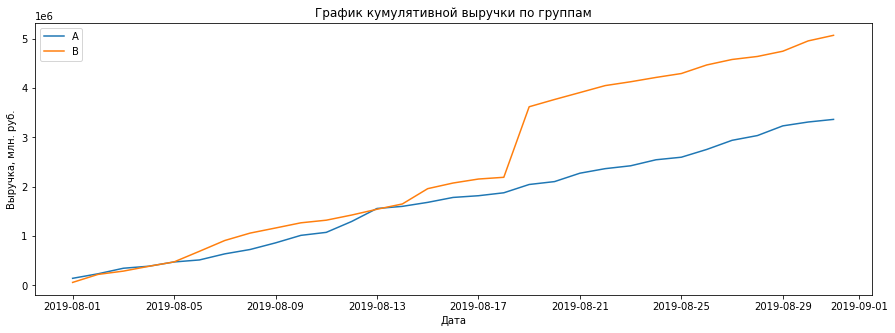

In [23]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


# Строим график выручки группы А
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'],label='B')

plt.legend() 
plt.title("График кумулятивной выручки по группам") 
plt.xlabel("Дата")
plt.ylabel("Выручка, млн. руб.")
plt.show() 



Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.
Однако график выручки в группе B 17.08 резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 
Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

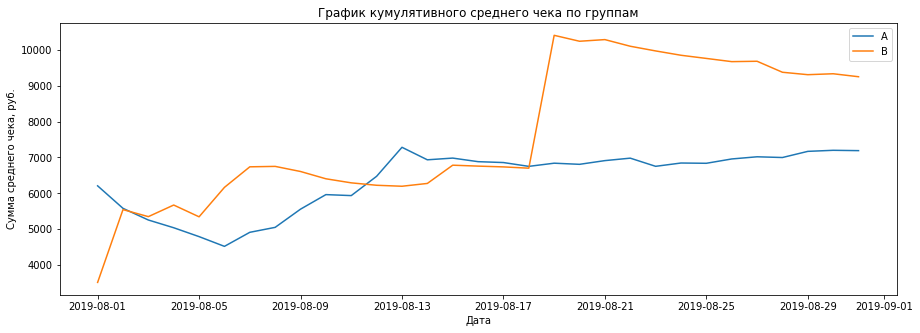

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title("График кумулятивного среднего чека по группам") 
plt.xlabel("Дата")
plt.ylabel("Сумма среднего чека, руб.")
plt.legend()

Средний чек тоже становится равномерным ближе к концу теста: установился для группы A и снижается для группы B. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.
Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline():

Text(0.5, 1.0, 'График относительного изменения кумулятивного среднего чека группы B к группе A')

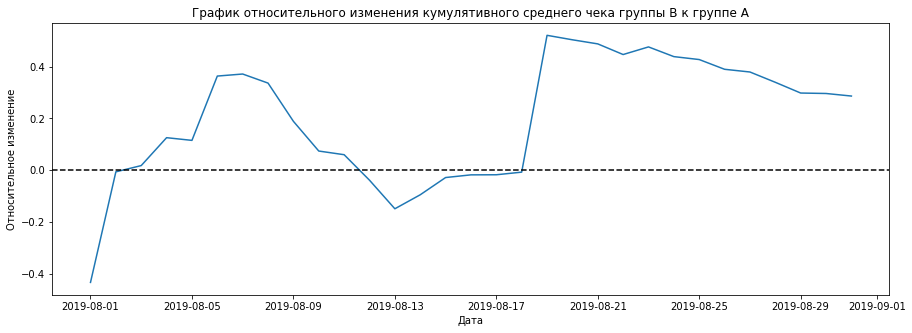

In [25]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xlabel("Дата")
plt.ylabel("Относительное изменение")
plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A")


В нескольких точках график различия между сегментами резко «скачет». Где-то уж точно спрятались крупные заказы и выбросы! Найдём их позже.

Аналогично проанализируем график кумулятивной конверсии. Зададим масштаб осей методом plt.axis(). Передадим ему минимальное и максимальное значения оси x; минимальное и максимальное значения оси y — ["2019-08-01", '2019-09-01', 0, 0.015]:

Text(0.5, 1.0, 'График кумулятивной конверсии по группам')

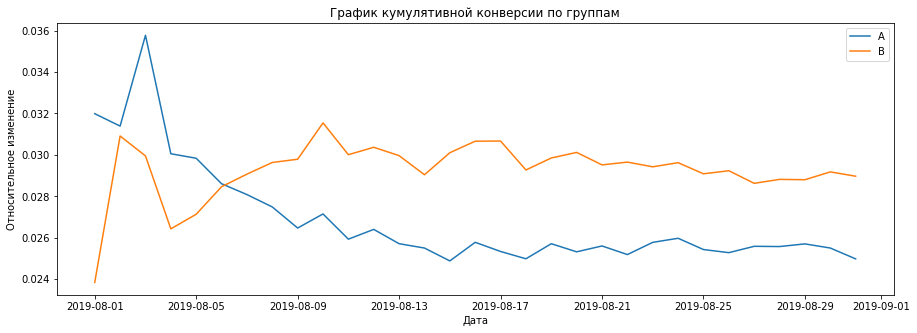

In [26]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Относительное изменение")
plt.title("График кумулятивной конверсии по группам")

Симметричный график получился! Группы колебались около одного значения, но затем конверсия группы В вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась.

Построим график относительного различия кумулятивных конверсий:

Text(0, 0.5, 'Относительное изменение')

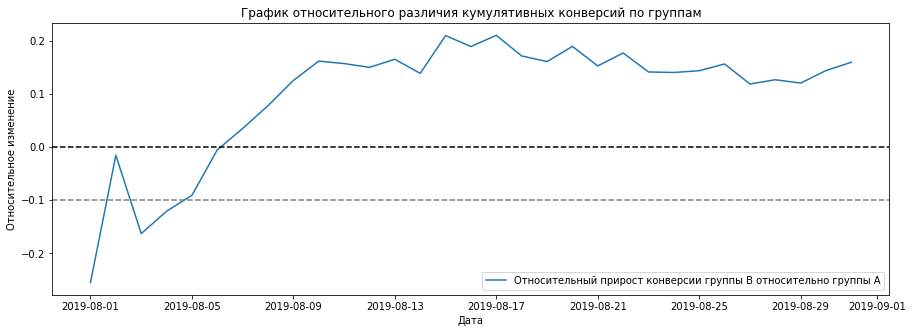

In [27]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title("График относительного различия кумулятивных конверсий по группам")
plt.xlabel("Дата")
plt.ylabel("Относительное изменение")


В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала, но теперь постепенно растёт.
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину.

#### Вывод

В данном разделе были изучены показатели следующих кумулятивных метрик:
- выручки
- среднего чека
- относительное изменение среднего чека группы В к группе А
- конверсии
- относительного изменения конверсии группы В к группе А

На первом графике мы наблюдаем резкий прирост выручки по группе В, что может свидетельствовать о повыении выручки или увеличению среднего чека по группе. Второй и третий графики укрепляют первое предположение о том,что повышение выручки по группе В связано с увеличением среднего чека. На четвертом и пятом графике мы видим,что конверсия по группе В значительно выше показателей конверсии по группе А. Для более точной картины нам следует исключить аномалии и выбросы.

### Анализ выбросов и всплесков: крайние значения данных.
<a id=step_three_two></a>

Построим точечный график количества заказов по пользователям. 
Для этого найдем уникальных пользователей и их количество заказов путем группировки таблицы.

In [28]:
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)

ordersByUsers.columns = ['userid', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 



         userid  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


Построим точечную диагармму количества заказов на одного пользователя

Text(0, 0.5, 'Количество заказов')

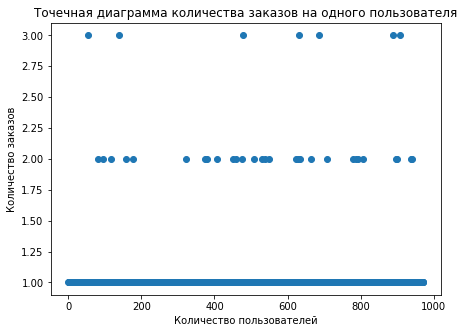

In [29]:
x_values = pd.Series(range(0,len(ordersByUsers)))

fig, ax = plt.subplots(figsize=(7, 5))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title("Точечная диаграмма количества заказов на одного пользователя")
plt.xlabel("Количество пользователей")
plt.ylabel("Количество заказов")

Большинство пользователей с 2-3 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.
Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [30]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформляли больше чем 2 заказа.
Установим нижнюю границу по количеству заказов на одного пользователя в пределах 2 заказов.

Построим точечный график стоимостей заказов.

Text(0, 0.5, 'Сумма заказа, руб.')

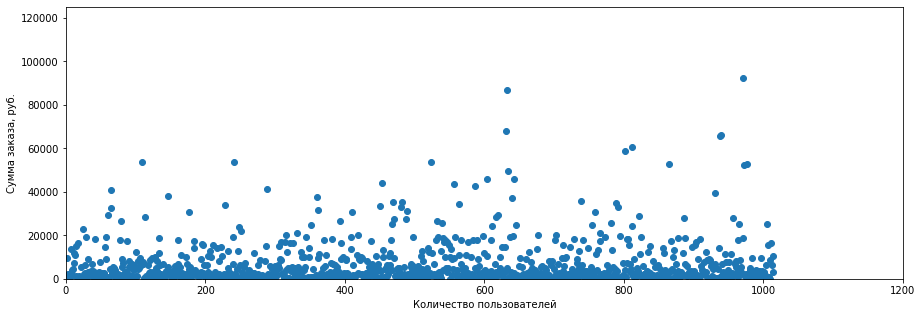

In [31]:
x_values = pd.Series(range(0,len(orders['revenue'])))
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(x_values, orders['revenue']) 
plt.axis([0, 1200, 0, 125000])
plt.xlabel("Количество пользователей")
plt.ylabel("Сумма заказа, руб.")

Всё, как предполагали: есть немного дорогих заказов. По графику можно выбрать границу аномальных заказов от 40 000 рублей. Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями. Для этого посчитаем 95-й и 99-й перцентили стоимости заказов.

In [32]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% заказов стоимостью дороже 28000 руб.,примем значение в 28000 как нижнюю границу стоимости заказа.

**Вывод**

При изучении точечных графиков и перцентилей по сумме заказа и количеству заказов были определены следующие границы для определения аномальных значений:
- количество заказов 2 шт.;
- сумма заказа 28 000 руб.


### Анализ A/B-теста шаг за шагом.
<a id=step_three_three></a>



#### Определение статистически значимых различий между группами по «сырым» данным.
<a id=step_three_three_one></a>

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

In [33]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

Уточним названия столбцов данных:

- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в конверсии между группами.
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами **['transactionid', 'visitorid']**. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [34]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorid', 'transactionid']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorid', 'transactionid'] 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [35]:
sampleA = pd.concat([ordersByUsersA['transactionid'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionid'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['transactionid'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionid'])), name='orders')],axis=0) 



Проверим гипотезы:
- H0 - Статистически значимых различий в конверсии между группами по "сырым данным" нет.
- H1 - Статистически значимые различия в конверсии между группами по "сырым данным" есть.

In [36]:
alpha = 0.05 # критический уровень статистической значимости
            # можно указать .05 или 0.05

results = stats.mannwhitneyu(sampleA, sampleB,alternative="two-sided")[1]

print("p-значение:{0:.3f}".format(results))

if results < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:0.011
Отвергаем нулевую гипотезу


Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой.

In [37]:
print("Относительный прирост конверсии группы B = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Относительный прирост конверсии группы B = 0.160


Нулевую гипотезу о том,что статистически значимых различий в конверсии между группами нет, не отвергаем,так как p-value больше 0,05.
Относительный прирост конверсии группы В составил 13,8%

Проверим гипотезы:
- H0 - Статистически значимых различий в значении среднего чека по "сырым данным" между группами нет.
- H1 - Статистически значимые различия в значении среднего чека по "сырым данным" между группами есть.

In [38]:
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'],alternative="two-sided")[1]

print("p-значение:{0:.3f}".format(results))

if results < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:0.829
Не получилось отвергнуть нулевую гипотезу


In [39]:
#найдём относительные различия в среднем чеке между группами:
print('Относительный прирост среднего чека группы В = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

Относительный прирост среднего чека группы В = 0.287


Средний чек группы В больше среднего чека группы А на 26%. При этом p-value больше 5%,в связи с этим нулевую гипотезу о том,что статистически значимых различий в показателях среднего чека между группами нет не отвергаем.

**Вывод**


Проверка "сырых" данных методом Манна-Уитни не опровергла нулевую гипотезу о том,что статистически значимых различий в конверсии и показателе среднего чека между группами нет.

При этом относительный прирост конверсии группы В больше группы А на 13,8%.
Относительный показатель среднего чека группы В больше на 26%.

#### Определение статистически значимых различий между группами по «очищенным» данным.
<a id=step_three_three_two></a>


Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ  на 28 000 рублей или дороже.
Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.


In [40]:
##Сделаем срезы пользователей с числом заказов больше 1 — usersWithManyOrders и пользователей,
##совершивших заказы дороже 27 999 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.


usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['transactionid'] > 1]['visitorid'],
        ordersByUsersB[ordersByUsersB['transactionid'] > 1]['visitorid'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] >= 28000]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
928     204675465
33      249864742
684     358944393
36      366673373
Name: visitorid, dtype: int64
(83,)


Всего 111 аномальных пользователей.
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. 

In [41]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))
        ]['transactionid'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionid'])
            ),
            name='transactionid',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))
        ]['transactionid'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionid'])
            ),
            name='transactionid',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам


Проверим гипотезы:
- H0 - Статистически значимых различий в конверсии между группами по "очищенным данным" нет.
- H1 - Статистически значимые различия в конверсии между группами по "очищенным данным" есть.

In [42]:
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered,alternative="two-sided")[1]

print("p-значение:{0:.3f}".format(results))

if results < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:0.012
Отвергаем нулевую гипотезу


In [43]:
print('Относительный прирост конверсии группы В = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Относительный прирост конверсии группы В = 0.181


Нулевая гипотеза о точ,что статистически значимых различий в конверсии между группами нет, отвергнута с p-value = 0.016
Относительный прирост группы В увеличился до 16,8%. Проверим как изменятся показатели по среднему чеку.

Проверим гипотезы:
- H0 - Статистически значимых различий в значении среднего чека между группами по "очищенным данным" нет.
- H1 - Статистически значимые различия в значении среднего чека между группами по "очищенным данным" есть.

In [44]:
results = (
    stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],alternative="two-sided"
        )[1]
    )


print("p-значение:{0:.3f}".format(results))

if results < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:0.851
Не получилось отвергнуть нулевую гипотезу


In [45]:
print(
    "Относительный прирост среднего чека группы В = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Относительный прирост среднего чека группы В = -0.006


Нулевая гипотеза о том,что статистических различий по среднему чеку групп нет,не была отвергнута, а также сильно изменился относительный прирост среднего чека по группе В.

**Вывод**

По очищенным данным была отвергнута гипотеза о том,что статистически значимых различий в конверсии между группами нет.
Не удалось отвергнуть гипотезу о наличии различий в среднем чеке.

Относительный прирост конверсии по группе В составил 16,8%.
Относительный прирост среднего чека по группе В составил -0,01%


## Общий вывод.
<a id=conclusion_id></a>


Первоначально были изучен перечень предоставленных гипотез с помощью фреймворка **ICE и RICE**.

При использовании способа ICE для приоретизации гипотез в топ 5 вошли гипотезы:

- предоставлении скидки в день рождение,
- добавлении новых каналов привлечения,
- добавлении формы подписки на все основне страницы,
- показе на главной странице баннеров с актуальными акциями и распродажами,
- добавлении рекомендаций на сайт интернет магазина.

При использовании способа RICE в топ 5 вошли гипотезы:

- добавлении формы подписки на все основные страницы;
- добавлении блоков рекомендаций товаров на сайт;
- добавлении двух новых каналов привленчения трафика;
- показе на главное странице баннеров с актуальными акциями и распродажами;
- запуске акции, дающую скидку на товар в день рождения.

По итогам применения фреймворков в топ 5 приоритетных были поставлены одни и те же гипотезы,но с различной последовательностью, так как при применении фреймворка RICE учитывается охват количества пользователей,которых затронут изменения.


В рамках проведения А/В тестирования были изучены следующие показатели кумулятивных метрик:

- выручки
- среднего чека
- относительного изменения среднего чека группы В к группе А
- конверсии
- относительного изменения конверсии группы В к группе А

При изучении кумулятивных метрик наблюдается явное преимущество группы В по показателям **выручки,среднего чека,конверсии.**

Резкое увеличение показателей может быть вызвано как увеличением выручки пользователей группы В,так и крупными заказами. Для определения природы данных изменений был проведен более подробный анализ данных.

При изучении точечных графиков и перцентилей по сумме заказа и количеству заказов были определены следующие границы для определения аномальных значений:
- количество заказов 2 шт.;
- сумма заказа 28 000 руб.

Далее были определены статистически значимые различия между группами по данным с учетом аномальных значений и без.

**Имеющиеся факты**:
- Нет статистически значимого различия по конверсии между группами по «сырым», но есть значимое различие по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A и есть значительная тенденция к улучшению:


Text(0, 0.5, 'Относительное различие')

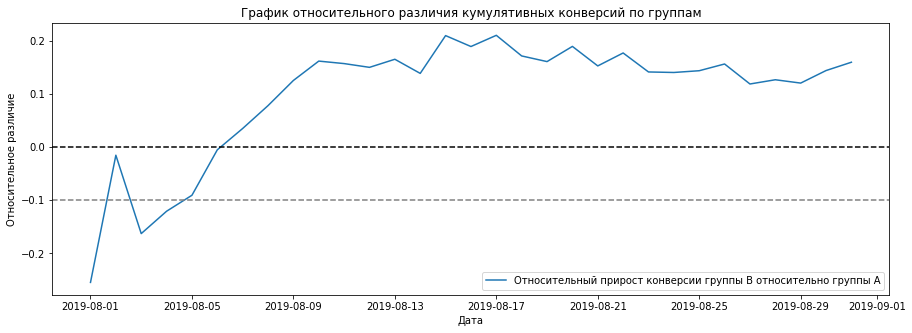

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title("График относительного различия кумулятивных конверсий по группам")
plt.xlabel("Дата")
plt.ylabel("Относительное различие")


График различия среднего чека сообщает о том, что результаты группы B резко повысились между 17 и 21 августа,но далее стоимость среднего чека начала снижаться.

Text(0, 0.5, 'Относительное различие')

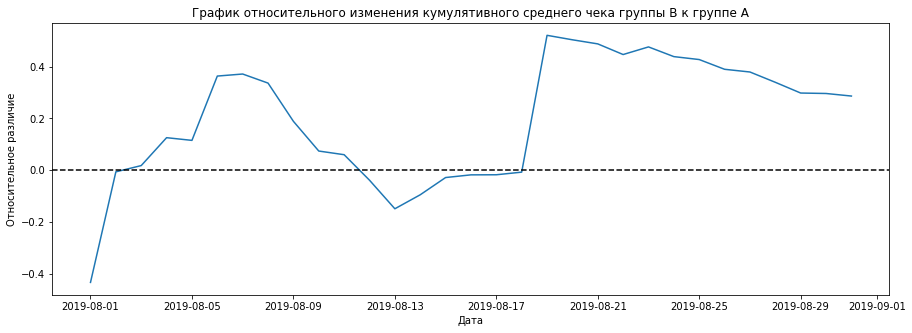

In [47]:
# cтроим отношение средних чеков
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A")
plt.xlabel("Дата")
plt.ylabel("Относительное различие")

**По результам проведенного А/В тестирования требуется остановить тест и признать его успешным.
При незначительном ухудшении средний стоимости чека на 0.01%,мы наблюдаем значительный прирост конверсии группы В на 16,8%.**